In [1]:
### Notebook takes 1:15 to run on Macbook Pro 2021
### On slower hardware it has taken up to 5:00 min. So please be patient.
### If the notebook is not being able to access the right folders, try restarting the kernel.

In [2]:
# Import dependencies and set global graph variables

import pandas as pd
import numpy as np
import yfinance as yf
from collections import Counter
import os
import glob
import math
from scipy import stats
import pandas_datareader as web
import datetime
import matplotlib.font_manager
import matplotlib.pyplot as plt
import statsmodels.api as sm_old
import statsmodels.formula.api as sm
%matplotlib inline

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 13})

In [3]:
# Get Sample Returns through Yahoo Finance API

sector_dict = {
    "health_care": [yf.Ticker("EXV4.DE"), "DE000A0Q4R36", "DE0006289374"],
    "travel_leisure": [yf.Ticker("EXV9.DE") ,"DE000A0H08S0", "DE0006344757"],
    "utilities": [yf.Ticker("EXH9.DE"), "DE000A0Q4R02", "DE0006289457"],
    "food_beverage": [yf.Ticker("EXH3.DE"), "DE000A0H08H3", "DE0006344781"],
    "banks": [yf.Ticker("EXV1.DE"), "DE000A0F5UJ7", "DE0006289341"],
    "personal_household": [yf.Ticker("EXH7.DE"), "DE000A0H08N1", "DE0006289432"],
    "construction_materials": [yf.Ticker("EXV8.DE"), "DE000A0H08F7", "DE0006344740"],
    "industrial_goods_services": [yf.Ticker("EXH4.DE"), "DE000A0H08J9", "DE0006344799"],
    "technology": [yf.Ticker("EXV3.DE"), "DE000A0H08Q4", "DE0006289366"],
    "telecommunications": [yf.Ticker("EXV2.DE"), "DE000A0H08R2", "DE0006289358"],
    "automobiles_parts": [yf.Ticker("EXV5.DE"), "DE000A0Q4R28", "DE0006344716"],
    "oil_gas": [yf.Ticker("EXH1.DE"), "DE000A0H08M3", "DE0006344765"],
    "basic_resources": [yf.Ticker("EXV6.DE"), "DE000A0F5UK5", "DE0006344724"],
    "media": [yf.Ticker("EXH6.DE"), "DE000A0H08L5", "DE0006289424"],
    "retail": [yf.Ticker("EXH8.DE"), "DE000A0H08P6", "DE0006289440"],
    "chemicals": [yf.Ticker("EXV7.DE"), "DE000A0H08E0", "DE0006344732"],
    "financial_services": [yf.Ticker("EXH2.DE"), "DE000A0H08G5", "DE0006344773"],
    "insurance": [yf.Ticker("EXH5.DE"), "DE000A0H08K7", "DE0006289416"],
}

def data_prep(input):
    hist = input.history(period="max")
    hist.reset_index(inplace=True)
    date_list = hist['Date'].tolist()
    date_list_fixed = [str(i) for i in date_list]
    new_list = []
    for i in date_list_fixed:
        new_list.append(i[0:10])
    hist["ProperDate"]=new_list
    df2 = hist[['Close', 'ProperDate']].copy()
    df2['year'] = df2.apply(lambda row: row.ProperDate[0:4], axis=1)
    df2['month'] = df2.apply(lambda row: row.ProperDate[5:7], axis=1)
    df2['day'] = df2.apply(lambda row: row.ProperDate[8:10], axis=1)
    return df2

In [4]:
# Check if returns are uniform, if not delete ETF with non-uniform data

answer_dict = {}
temp_list = []
for i in sector_dict:
    answer_dict[i] = data_prep(sector_dict[i][0])
    temp_list.append(answer_dict[i].iloc[0]["ProperDate"])


def date_check(input_dates):
    if input_dates.count(input_dates[0]) == len(input_dates):
        return ("PASS")
    else:
        return ("FAIL")


print(f"Same Start Date Check: {date_check(temp_list)}")

len_dict = {}
for i in answer_dict:
    len_dict[i] = len(answer_dict[i])

values_list = list(len_dict.values())
common_val = max(set(values_list), key=values_list.count)

drop_dict = {}
for i in len_dict:
    if len_dict[i] == common_val:
        drop_dict[i] = "TRUE"
    else:
        drop_dict[i] = "FALSE"

for i in drop_dict:
    if drop_dict[i] == "TRUE":
        pass
    else:
        print(f"{[i]} got deleted")
        del answer_dict[i]
        

Same Start Date Check: PASS
['technology'] got deleted


In [5]:
# Add individual ETF data to shared dataframe. Also prepare scanning for XLM data for each ETF

result_df = answer_dict[list(answer_dict.keys())[0]][["ProperDate", "day", "month", "year"]]

intermediate_dict = {}
for i in answer_dict:
    temp_list = answer_dict[i].Close.tolist()
    intermediate_dict[i] = temp_list

for i in intermediate_dict:
    result_df[i] = intermediate_dict[i]

start_wd = os.getcwd()
os.chdir(start_wd + "/XLM data")
path = os.getcwd()
path_length = len(path)

csv_files_test = glob.glob(os.path.join(path, "*.csv"))
csv_files_test.sort()

column_names = ["date", "XLM"]
other_df = pd.DataFrame(columns=column_names)

def traverse(a):
    if not isinstance(a, list):
        yield a
    else:
        for e in a:
            yield from traverse(e)


In [6]:
# Scan for XLM data for each ETF in dataset and create dataframe with all the XLM data

xlm_list = []
order_book_list = []
for f in csv_files_test:
    x = f[path_length + 1:path_length + 7]
    y = int(x)
    if y >= 200910:
        df = pd.read_csv(f)
        df.columns = df.iloc[3]
        df = df[4:]
        df.reset_index(drop=True)
        df.columns = df.columns.astype(str)
        df.drop(list(df.filter(regex = 'nan')), axis = 1, inplace = True)
        xlm_list.append([col for col in df.columns if 'XLM' in col])
        order_book_list.append([col for col in df.columns if 'Order Book' in col])
    else: 
        df = pd.read_csv(f)
        df.columns = df.iloc[2]
        df = df[3:]
        df.reset_index(drop=True)
        df.columns = df.columns.astype(str)
        df.drop(list(df.filter(regex = 'nan')), axis = 1, inplace = True)
        xlm_list.append([col for col in df.columns if 'XLM' in col])
        order_book_list.append([col for col in df.columns if 'Order Book' in col])

xlm_options = list(traverse(xlm_list))
order_book_options = list(traverse(order_book_list))
xlm_myset = list(set(xlm_options))
order_book_myset = list(set(order_book_options))

column_names = ["month", "year"]
xlm_df = pd.DataFrame(columns=column_names)

for f in csv_files_test:
    x = f[path_length + 1:path_length + 7]
    y = int(x)
    if y >= 200910:
        df = pd.read_csv(f)
        df.columns = df.iloc[3]
        df = df[4:]
        df.reset_index(drop=True)
        df.columns = df.columns.astype(str)
        df.drop(list(df.filter(regex = 'nan')), axis = 1, inplace = True)
        for i in order_book_myset:
            if i in df.columns:
                month = df.iloc[0][i][0:2]
                year = df.iloc[0][i][3:7]
        input = {"month" : month, "year": year}
        xlm_df = xlm_df.append(input, ignore_index=True)
    else:
        df = pd.read_csv(f)
        df.columns = df.iloc[2]
        df = df[3:]
        df.reset_index(drop=True)
        df.columns = df.columns.astype(str)
        df.drop(list(df.filter(regex = 'nan')), axis = 1, inplace = True)
        for i in order_book_myset:
            if i in df.columns:
                month = df.iloc[0][i][0:2]
                year = df.iloc[0][i][3:7]
        input = {"month" : month, "year": year}
        xlm_df = xlm_df.append(input, ignore_index=True)

xlm_df.sort_values(by=['year','month'], inplace=True)

for i in sector_dict:
    xlm_df[i] = np.nan

for f in csv_files_test:
    for entry in sector_dict:
      x = f[path_length + 1:path_length + 7]
      y = int(x)
      if y >= 200910:
        df = pd.read_csv(f)
        df.columns = df.iloc[3]
        df = df[4:]
        df.reset_index(drop=True)
        df.columns = df.columns.astype(str)
        df.drop(list(df.filter(regex = 'nan')), axis = 1, inplace = True)
        if xlm_myset:  
          for i in xlm_myset:
            if i in df.columns:
              df_result = df.rename({i: 'XLM'}, axis=1)
        else:
          df_result = df
          df_result["XLM"] = np.nan
        for i in order_book_myset:
          if i in df_result.columns:
            month = df_result.iloc[0][i][0:2]
            year = df_result.iloc[0][i][3:7]
        if "XLM" in df_result.columns:
          if y < 201106:
            value = df_result.loc[df_result['ISIN'] == sector_dict[entry][2], "XLM"]
          else:
            value = df_result.loc[df_result['ISIN'] == sector_dict[entry][1], "XLM"]
        else:
          value = np.nan
        xlm_df[entry] = np.where((xlm_df["year"] == year) & (xlm_df["month"] == month) , value, xlm_df[entry])
      else:
        df = pd.read_csv(f)
        df.columns = df.iloc[2]
        df = df[3:]
        df.reset_index(drop=True)
        df.columns = df.columns.astype(str)
        df.drop(list(df.filter(regex = 'nan')), axis = 1, inplace = True)
        if xlm_myset:  
          for i in xlm_myset:
            df_result = df.rename({i: 'XLM'}, axis=1) 
        else:
          df_result = df
          df_result["XLM"] = np.nan
        for i in order_book_myset:
          if i in df_result.columns:
            month = df_result.iloc[0][i][0:2]
            year = df_result.iloc[0][i][3:7]
        if "XLM" in df_result.columns:
          value = df_result.loc[df_result['ISIN'] == sector_dict[entry][2], "XLM"]
        else:
          value = np.nan
        xlm_df[entry] = np.where((xlm_df["year"] == year) & (xlm_df["month"] == month) , value, xlm_df[entry])

xlm_df.reset_index(drop=True, inplace=True)

for i in xlm_df.columns[2:]:
    xlm_df[i] = xlm_df[i].astype(float)

xlm_test = xlm_df.copy()
xlm_df = xlm_test.interpolate()

start_index = len(xlm_df[xlm_df.isna().any(axis=1)])

for i in xlm_df.columns[2:]:
  xlm_df[i].fillna((xlm_df[i][start_index:start_index+24].mean()), inplace=True)

/var/folders/mz/j0cx373n65bfdx6knq_mx3yr0000gn/T/ipykernel_3156/3135163797.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xlm_df = xlm_df.append(input, ignore_index=True)
/var/folders/mz/j0cx373n65bfdx6knq_mx3yr0000gn/T/ipykernel_3156/3135163797.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xlm_df = xlm_df.append(input, ignore_index=True)
/var/folders/mz/j0cx373n65bfdx6knq_mx3yr0000gn/T/ipykernel_3156/3135163797.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xlm_df = xlm_df.append(input, ignore_index=True)
/var/folders/mz/j0cx373n65bfdx6knq_mx3yr0000gn/T/ipykernel_3156/3135163797.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

/var/folders/mz/j0cx373n65bfdx6knq_mx3yr0000gn/T/ipykernel_3156/4149543006.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  xlm_print["Mean XLM"] = xlm_print.mean(axis=1)


<AxesSubplot:xlabel='Year', ylabel='XLM in bp'>

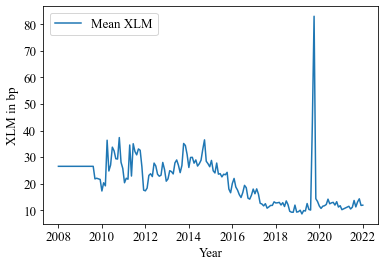

In [7]:
# Plot mean XLM values over sample period

xlm_print = xlm_df.copy()
xlm_print["Mean XLM"] = xlm_print.mean(axis=1)
xlm_plot = xlm_print.plot(x="year", y="Mean XLM", yticks=[10,20,30,40,50,60,70,80])
xlm_plot.set_xlabel("Year")
xlm_plot.set_ylabel("XLM in bp")
xlm_plot

In [8]:
# Merge XLM values with ETF price info. Create iNAV dataframe

for i in xlm_df.columns[2:]:
    new_name = i + "_xlm"
    xlm_df.rename({i: new_name}, axis=1, inplace=True)

for i in xlm_df.columns[2:]:
    xlm_df[i] = xlm_df[i].apply(lambda x: x/10000)

res = result_df.merge(xlm_df, how='inner', left_on=['month', 'year'], right_on=['month', 'year'])

os.chdir(start_wd + "/iNAV data")
path = os.getcwd()
path_length = len(path)
csv_files_test = glob.glob(os.path.join(path, "*.csv"))


for f in csv_files_test:
    df = pd.read_csv(f)
    df.columns = df.iloc[16]
    df.reset_index(drop=True)
    df = df[17:]
    df.columns = df.columns.astype(str)
    df.drop(list(df.filter(regex = 'nan')), axis = 1, inplace = True)
    year = df.iloc[0]["Exchange Date"][0:4]
    month = df.iloc[0]["Exchange Date"][5:7]
    day = df.iloc[0]["Exchange Date"][8:11]
    close = df.iloc[0]["Close"]

reference_df = pd.read_csv(csv_files_test[0])
reference_df.columns = reference_df.iloc[16]
reference_df.reset_index(drop=True)
reference_df = reference_df[17:]
reference_df.columns = reference_df.columns.astype(str)
reference_df.drop(list(reference_df.filter(regex = 'nan')), axis = 1, inplace = True)
reference_df.reset_index(drop=True, inplace=True)

column_names = ["full_date"]
inav_df = pd.DataFrame(columns=column_names)

inav_df["full_date"] = reference_df["Exchange Date"]

inav_df['ProperDate'] = inav_df.full_date.str[0:10]
inav_df['day'] = inav_df.full_date.str[8:10]
inav_df['month'] = inav_df.full_date.str[5:7]
inav_df['year'] = inav_df.full_date.str[0:4]
inav_df.reset_index(drop=True,inplace=True)

for f in csv_files_test:
    x = f[path_length+1:-4] + "_iNAV"
    inav_df[x] = np.nan


In [9]:
print(path)
path_length

/Users/max/Documents/Thesis/Max Individual Part Thesis - submission/iNAV data


77

In [10]:
for f in csv_files_test:
    x = f[path_length:-4] + "_iNAV"
    print(x)

/construction_materials_iNAV
/media_iNAV
/health_care_iNAV
/technology_iNAV
/financial_services_iNAV
/insurance_iNAV
/utilities_iNAV
/industrial_goods_services_iNAV
/oil_gas_iNAV
/retail_iNAV
/chemicals_iNAV
/telecommunications_iNAV
/basic_resources_iNAV
/travel_leisure_iNAV
/automobiles_parts_iNAV
/food_beverage_iNAV
/personal_household_iNAV
/banks_iNAV


In [11]:
# Populate iNAV dataframe with the appropriate iNAV values from the data

for f in csv_files_test:
    x = f[path_length + 1:-4] + "_iNAV"
    print(x)
    df = pd.read_csv(f)
    df.columns = df.iloc[16]
    df.reset_index(drop=True)
    df = df[17:]
    df.columns = df.columns.astype(str)
    df.drop(list(df.filter(regex = 'nan')), axis = 1, inplace = True)
    df.dropna(inplace = True)
    year = df.iloc[0]["Exchange Date"][0:4]
    month = df.iloc[0]["Exchange Date"][5:7]
    day = df.iloc[0]["Exchange Date"][8:11]
    value = df.iloc[1]["Close"]

    for i in range(len(df)):
        exchange_date = df.iloc[i]["Exchange Date"]
        year = df.iloc[i]["Exchange Date"][0:4]
        month = df.iloc[i]["Exchange Date"][5:7]
        day = df.iloc[i]["Exchange Date"][8:11]
        value = df.iloc[i]["Close"]
        inav_df[x] = np.where((inav_df["full_date"] == exchange_date) , value, inav_df[x])

inav_df.sort_values(by=['year','month', 'day'], inplace=True)
inav_df.reset_index(drop=True,inplace=True)

construction_materials_iNAV
media_iNAV
health_care_iNAV
technology_iNAV
financial_services_iNAV
insurance_iNAV
utilities_iNAV
industrial_goods_services_iNAV
oil_gas_iNAV
retail_iNAV
chemicals_iNAV
telecommunications_iNAV
basic_resources_iNAV
travel_leisure_iNAV
automobiles_parts_iNAV
food_beverage_iNAV
personal_household_iNAV
banks_iNAV


In [12]:
# Merge ETF Price + XLM Data with the iNAV figures

final_df = res.merge(inav_df, how='inner', left_on=["ProperDate"], right_on=["ProperDate"])

In [13]:
# Drop duplicate columns

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

drop_y(final_df)

def rename_x(df):
    for col in df:
        if col.endswith('_x'):
            df.rename(columns={col:col.rstrip('_x')}, inplace=True)

rename_x(final_df)

drop_list = []
for i in drop_dict:
    if drop_dict[i] == "FALSE":
        drop_list.append(i)

new_dict = {}
for i in sector_dict:
    new_dict[i] = i + "_iNAV"
    
for i in drop_list:
    new_dict.pop(i, None)

In [14]:
final_df.columns

Index(['ProperDate', 'day', 'month', 'year', 'health_care', 'travel_leisure',
       'utilities', 'food_beverage', 'banks', 'personal_household',
       'construction_materials', 'industrial_goods_services',
       'telecommunications', 'automobiles_parts', 'oil_gas', 'basic_resources',
       'media', 'retail', 'chemicals', 'financial_services', 'insurance',
       'health_care_xlm', 'travel_leisure_xlm', 'utilities_xlm',
       'food_beverage_xlm', 'banks_xlm', 'personal_household_xlm',
       'construction_materials_xlm', 'industrial_goods_services_xlm',
       'technology_xlm', 'telecommunications_xlm', 'automobiles_parts_xlm',
       'oil_gas_xlm', 'basic_resources_xlm', 'media_xlm', 'retail_xlm',
       'chemicals_xlm', 'financial_services_xlm', 'insurance_xlm', 'full_date',
       'construction_materials_iNAV', 'media_iNAV', 'health_care_iNAV',
       'technology_iNAV', 'financial_services_iNAV', 'insurance_iNAV',
       'utilities_iNAV', 'industrial_goods_services_iNAV', 'oil_g

In [15]:
# Calculate spread between ETF Price and iNAV

final_df.drop('full_date', axis=1, inplace=True)

for i in final_df.columns[4:]:
    final_df[i] = final_df[i].astype(float)

for i in new_dict:     
        def calculate_dif(row):
                return row[i] / row[new_dict[i]]
        final_df[i + "_dif"] = final_df.apply(calculate_dif, axis=1)

In [16]:
diff_df = final_df[list(final_df.columns[57:])].copy()

In [17]:
### IMPORTANT: Choose Strategy Position Size (e.g. top_n = 1 ==> go long on the 1 most discounted ETF and short on the 1 most overpriced ETF)

top_n = 1

In [18]:
# Spread info summarized

ratio_df = diff_df.copy()
ratio_df["Max Premium"] = ratio_df.max(axis=1)
ratio_df["Max Discount"] = ratio_df.min(axis=1)
ratio_df = ratio_df.drop(ratio_df.columns[0:-2], axis=1)
ratio_df["year"] = final_df["year"]

<AxesSubplot:xlabel='Year', ylabel='Price to iNAV Ratio'>

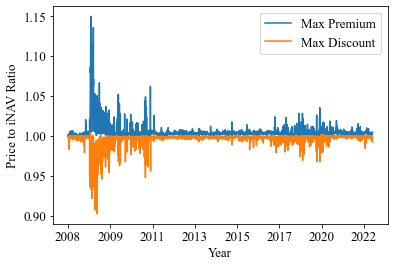

In [19]:
# Spread Graph

premium_plot = ratio_df.plot(y=["Max Premium", "Max Discount"], x="year")
premium_plot.set_xlabel("Year")
premium_plot.set_ylabel("Price to iNAV Ratio")
premium_plot

In [20]:
# From spread info dataframe, find ETF with highest (n = top_n) premium and discount

short = pd.DataFrame({n: diff_df.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(diff_df.T)}).T
short["ProperDate"] = final_df["ProperDate"]

long = pd.DataFrame({n: diff_df.T[col].nsmallest(top_n).index.tolist() 
                  for n, col in enumerate(diff_df.T)}).T
long["ProperDate"] = final_df["ProperDate"]

In [21]:
# Calculate entry and exit prices for positions

for i in new_dict:     
        def calculate_dif(row):
                return row[i] / row[new_dict[i]]
        final_df[i + "_dif"] = final_df.apply(calculate_dif, axis=1)

def get_position(row):
    return list(row[0:top_n])

final_df["long_position"] = long.apply(get_position, axis=1)
final_df["short_position"] = short.apply(get_position, axis=1)


transaction_fee = 0.000048

def get_price_short(row):
    temp_list = []
    for i in row["short_position"]:
        x = i[0:-4]
        xlm_part = i[0:-4] + "_xlm"
        transaction_cost = (row[x] - (0.5 * (row[xlm_part] * row[x]))) * transaction_fee
        y = (row[x] - (0.5 * (row[xlm_part] * row[x]))) - transaction_cost
        temp_list.append(y)
    return sum(temp_list)

def get_price_short_sale(row):
    if isinstance(row["short_position_tminus1"], float):
        return np.nan
    else:
        temp_list = []
        for i in row["short_position_tminus1"]:
            x = i[0:-4]
            xlm_part = i[0:-4] + "_xlm"
            transaction_cost = (row[x] + (0.5 * (row[xlm_part] * row[x]))) * transaction_fee
            y = (row[x] + (0.5 * (row[xlm_part] * row[x]))) + transaction_cost
            temp_list.append(y)
        return sum(temp_list)

def get_price_long(row):
    temp_list = []
    for i in row["long_position"]:
        x = i[0:-4]
        xlm_part = i[0:-4] + "_xlm"
        transaction_cost = (row[x] + (0.5 * (row[xlm_part] * row[x]))) * transaction_fee
        y = (row[x] + (0.5 * (row[xlm_part] * row[x]))) + transaction_cost
        temp_list.append(y)
    return sum(temp_list)

def get_price_long_sale(row):
    if isinstance(row["long_position_tminus1"], float):
        return np.nan
    else:
        temp_list = []
        for i in row["long_position_tminus1"]:
            x = i[0:-4]
            xlm_part = i[0:-4] + "_xlm"
            transaction_cost = (row[x] - (0.5 * (row[xlm_part] * row[x]))) * transaction_fee
            y = (row[x] - (0.5 * (row[xlm_part] * row[x]))) - transaction_cost
            temp_list.append(y)
        return sum(temp_list)

In [22]:
# Duplicate dataframe for later no transaction cost analysis

no_ta_final_df = final_df.copy() 

In [23]:
# Calculate Returns

final_df["long_buy"] = final_df.apply(get_price_long, axis=1)
final_df['long_position_tminus1'] = final_df.long_position.shift(1)
final_df["long_sell"] = final_df.apply(get_price_long_sale, axis=1)

final_df["short_buy"] = final_df.apply(get_price_short, axis=1)
final_df['short_position_tminus1'] = final_df.short_position.shift(1)
final_df["short_sell"] = final_df.apply(get_price_short_sale, axis=1)

final_df['short_long_ratio'] = final_df.apply(lambda row: row.short_buy / row.long_buy, axis=1)
final_df['short_long_ratio_tminus1'] = final_df.short_long_ratio.shift(1)

final_df['long_buy_tminus1'] = final_df.long_buy.shift(1)
final_df['short_buy_tminus1'] = final_df.short_buy.shift(1)

final_df['long_weight'] = 0.5
final_df['short_weight'] = 0.5

final_df['long_return'] = final_df.apply(lambda row: row.long_sell - row.long_buy_tminus1, axis=1)
final_df['long_return_pct'] = final_df.apply(lambda row: ((row.long_sell - row.long_buy_tminus1) / row.long_buy_tminus1) , axis=1)
final_df['long_return_log'] = final_df.apply(lambda row: math.log(1 + row.long_return_pct) , axis=1)

final_df['short_return'] = final_df.apply(lambda row: row.short_buy_tminus1 - row.short_sell, axis=1)
final_df['short_return_pct'] = final_df.apply(lambda row: ((row.short_buy_tminus1 - row.short_sell) / row.short_sell) , axis=1)
final_df['short_return_log'] = final_df.apply(lambda row: math.log(1 + row.short_return_pct) , axis=1)

final_df['total_return'] = final_df.apply(lambda row: row.long_return + row.short_return, axis=1)
final_df['total_return_pct'] = final_df.apply(lambda row: row.long_return_pct * row.long_weight + row.short_return_pct * row.short_weight, axis=1)
final_df['total_return_log'] = final_df.apply(lambda row: math.log(1 + row.total_return_pct) , axis=1)

final_df["cum_return_long_log"] = 1 + final_df["long_return_log"].cumsum()
final_df["cum_return_short_log"] = 1 + final_df["short_return_log"].cumsum()
final_df["cum_return_total_log"] = 1 + final_df["total_return_log"].cumsum()

<AxesSubplot:title={'center':'Cumulative Short-Only Return'}, xlabel='Year', ylabel='Cumulative Log Return'>

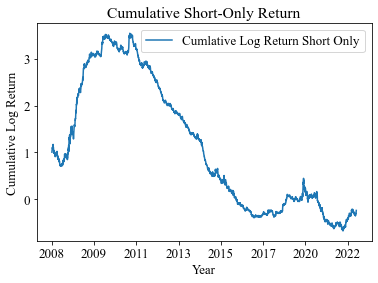

In [24]:
# Plot short-only strategy returns

short_plot = final_df.plot(x='year', y='cum_return_short_log', title="Cumulative Short-Only Return")
short_plot.set_xlabel("Year")
short_plot.set_ylabel("Cumulative Log Return")
plt.legend(["Cumlative Log Return Short Only"])
short_plot

<AxesSubplot:title={'center':'Cumulative Long-Only Return'}, xlabel='Year', ylabel='Cumulative Log Return'>

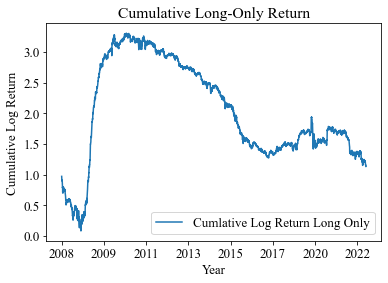

In [25]:
# Plot long-only strategy returns

long_plot = final_df.plot(x='year', y='cum_return_long_log', title="Cumulative Long-Only Return")
long_plot.set_xlabel("Year")
long_plot.set_ylabel("Cumulative Log Return")
plt.legend(["Cumlative Log Return Long Only"])
long_plot

<AxesSubplot:xlabel='Year', ylabel='Cumulative Log Return'>

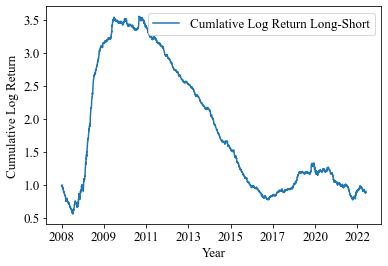

In [26]:
# Plot complete strategy returns

combined_plot = final_df.plot(x='year', y='cum_return_total_log')#, title="Long-Short Strategy Cumulative Returns")
combined_plot.set_xlabel("Year")
combined_plot.set_ylabel("Cumulative Log Return")
plt.legend(["Cumlative Log Return Long-Short"])
combined_plot

In [27]:
# Create performance overview dataframe

overview_df_log = pd.DataFrame(index=final_df[["total_return_pct", "year"]].groupby("year").mean()["total_return_pct"].index)
overview_df_log.rename_axis('Year')

overview_df_log["Mean Short"] = final_df[["short_return_log", "year"]].groupby("year").mean()["short_return_log"]
overview_df_log["Mean Long"] = final_df[["long_return_log", "year"]].groupby("year").mean()["long_return_log"]
overview_df_log["Mean Total"] = final_df[["total_return_log", "year"]].groupby("year").mean()["total_return_log"]
overview_df_log["STDev"] = final_df[["total_return_log", "year"]].groupby("year").std()["total_return_log"]
overview_df_log["Min"] = final_df[["total_return_log", "year"]].groupby("year").min()["total_return_log"]
overview_df_log["Max"] = final_df[["total_return_log", "year"]].groupby("year").max()["total_return_log"]
overview_df_log

,Mean Short,Mean Long,Mean Total,STDev,Min,Max
year,,,,,,
2008,0.001580,-0.002928,-0.000227,0.013162,-0.060087,0.058617
2009,0.006543,0.010455,0.008687,0.015772,-0.044247,0.071698
2010,0.001180,0.001375,0.001383,0.009153,-0.014982,0.086517
2011,-0.000955,-0.000464,-0.000570,0.008750,-0.030251,0.033434
2012,-0.002853,-0.000740,-0.001721,0.005453,-0.018598,0.017090
2013,-0.002504,-0.000816,-0.001620,0.004745,-0.018243,0.018510
2014,-0.002384,-0.001340,-0.001812,0.004470,-0.018686,0.011497
2015,-0.003225,-0.001252,-0.002150,0.005367,-0.018473,0.021025
2016,-0.002175,-0.002277,-0.002103,0.006680,-0.034322,0.016915


In [28]:
# Find XLM mean value for entire sample

xlm_df[xlm_df.columns[2:]].mean().mean()

0.0021049876757293076

In [29]:
# Import FF3 data and prepare it

os.chdir(start_wd + "/FF3 data")
path = os.getcwd()

ff3_df = pd.read_csv("Europe_3_Factors_Daily.csv")

ff3_df['Date'] = ff3_df['Date'].astype(str)

ff3_df["ProperDate"] = ff3_df.apply(lambda row: row.Date[0:4] + "-" + row.Date[4:6] + "-" + row.Date[6:8], axis=1)
ff3_df.drop(['Date', "mkt-rf"], axis=1, inplace=True)

factor_list = ["smb", "hml", "rf"]
for i in factor_list:
    ff3_df[i] = ff3_df[i].div(100)

In [30]:
# Import stoxx600 index data. Prepare regression dataframe (market and factor excess return data)

stoxx600 = yf.Ticker("^STOXX")
stoxx600_df = data_prep(stoxx600)
stoxx600_df['stoxx600_return'] = (stoxx600_df['Close'].pct_change())
stoxx600_df['stoxx600_return_log'] = stoxx600_df.apply(lambda row: math.log(1 + row.stoxx600_return) , axis=1)

capm_ff3_df = ff3_df.merge(stoxx600_df, how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
capm_ff3_df['stoxx600_return_excess'] = capm_ff3_df.apply(lambda row: row.stoxx600_return - row.rf, axis=1)
capm_ff3_df['stoxx600_excess_log'] = capm_ff3_df.apply(lambda row: math.log(1 + row.stoxx600_return_excess) , axis=1)

regression_df = final_df.merge(capm_ff3_df, how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
drop_y(regression_df)
rename_x(regression_df)
regression_df['smb_log'] = regression_df.apply(lambda row: math.log(1 + row.smb) , axis=1)
regression_df['hml_log'] = regression_df.apply(lambda row: math.log(1 + row.hml) , axis=1)
regression_df['short_return_pct_excess'] = regression_df.apply(lambda row: row.short_return_pct - row.rf, axis=1)
regression_df['long_return_pct_excess'] = regression_df.apply(lambda row: row.long_return_pct - row.rf, axis=1)
regression_df['total_return_pct_excess'] = regression_df.apply(lambda row: row.total_return_pct - row.rf, axis=1)
regression_df['short_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.short_return_pct_excess) , axis=1)
regression_df['long_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.long_return_pct_excess) , axis=1)
regression_df['total_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.total_return_pct_excess) , axis=1)

In [31]:
# Regress total- and substrategies using ff3 model

return_list = [regression_df["short_return_log_excess"], regression_df["long_return_log_excess"], regression_df["total_return_log_excess"]]

for i in return_list:
  factors = ['stoxx600_excess_log', 'smb_log', 'hml_log']

  Y_ff3 = i
  X_ff3 = regression_df[factors]
  X_sm_ff3 = sm_old.add_constant(X_ff3)
  ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
  ff3_results = ff3_model.fit()
  print(ff3_results.summary())
  print(" ")

                               OLS Regression Results                              
Dep. Variable:     short_return_log_excess   R-squared:                       0.528
Model:                                 OLS   Adj. R-squared:                  0.527
Method:                      Least Squares   F-statistic:                     1320.
Date:                     Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                             17:16:51   Log-Likelihood:                 10550.
No. Observations:                     3550   AIC:                        -2.109e+04
Df Residuals:                         3546   BIC:                        -2.107e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [32]:
# Regress total- and substrategies using capm model

return_list = [regression_df["short_return_log_excess"], regression_df["long_return_log_excess"], regression_df["total_return_log_excess"]]

for i in return_list:
  Y_capm = i
  X_capm = regression_df["stoxx600_excess_log"]
  X_sm_capm = sm_old.add_constant(X_capm)
  capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
  capm_results = capm_model.fit()
  print(capm_results.summary())
  print(" ")

                               OLS Regression Results                              
Dep. Variable:     short_return_log_excess   R-squared:                       0.521
Model:                                 OLS   Adj. R-squared:                  0.521
Method:                      Least Squares   F-statistic:                     3858.
Date:                     Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                             17:16:51   Log-Likelihood:                 10526.
No. Observations:                     3550   AIC:                        -2.105e+04
Df Residuals:                         3548   BIC:                        -2.103e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [33]:
# FF3 regression for only the positive return years in the sample

answer_list = []
for i in list(final_df[["total_return_log", "year"]].groupby("year").mean()["total_return_log"].index):
  if (final_df[["total_return_log", "year"]].groupby("year").mean()["total_return_log"])[i] >= 0:
    answer_list.append(i)
    
pos_df = final_df.loc[final_df['year'].isin(answer_list)]

regression_df = pos_df.merge(capm_ff3_df, how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
drop_y(regression_df)
rename_x(regression_df)
regression_df['smb_log'] = regression_df.apply(lambda row: math.log(1 + row.smb) , axis=1)
regression_df['hml_log'] = regression_df.apply(lambda row: math.log(1 + row.hml) , axis=1)
regression_df['short_return_pct_excess'] = regression_df.apply(lambda row: row.short_return_pct - row.rf, axis=1)
regression_df['long_return_pct_excess'] = regression_df.apply(lambda row: row.long_return_pct - row.rf, axis=1)
regression_df['total_return_pct_excess'] = regression_df.apply(lambda row: row.total_return_pct - row.rf, axis=1)
regression_df['short_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.short_return_pct_excess) , axis=1)
regression_df['long_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.long_return_pct_excess) , axis=1)
regression_df['total_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.total_return_pct_excess) , axis=1)

return_list = [regression_df["short_return_log_excess"], regression_df["long_return_log_excess"], regression_df["total_return_log_excess"]]

for i in return_list:
  factors = ['stoxx600_excess_log', 'smb_log', 'hml_log']

  Y_ff3 = i
  X_ff3 = regression_df[factors]
  X_sm_ff3 = sm_old.add_constant(X_ff3)
  ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
  ff3_results = ff3_model.fit()
  print(ff3_results.summary())
  print(" ")

for i in return_list:
  Y_capm = i
  X_capm = regression_df["stoxx600_excess_log"]
  X_sm_capm = sm_old.add_constant(X_capm)
  capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
  capm_results = capm_model.fit()
  print(capm_results.summary())
  print(" ")

                               OLS Regression Results                              
Dep. Variable:     short_return_log_excess   R-squared:                       0.433
Model:                                 OLS   Adj. R-squared:                  0.432
Method:                      Least Squares   F-statistic:                     331.4
Date:                     Thu, 15 Dec 2022   Prob (F-statistic):          7.34e-160
Time:                             17:16:51   Log-Likelihood:                 3670.9
No. Observations:                     1306   AIC:                            -7334.
Df Residuals:                         1302   BIC:                            -7313.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [34]:
# # FF3 regression for only the non-positive return years in the sample

answer_list = []
for i in list(final_df[["total_return_log", "year"]].groupby("year").mean()["total_return_log"].index):
  if (final_df[["total_return_log", "year"]].groupby("year").mean()["total_return_log"])[i] >= 0:
    answer_list.append(i)
    
pos_df = final_df.loc[~final_df['year'].isin(answer_list)]

regression_df = pos_df.merge(capm_ff3_df, how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
drop_y(regression_df)
rename_x(regression_df)
regression_df['smb_log'] = regression_df.apply(lambda row: math.log(1 + row.smb) , axis=1)
regression_df['hml_log'] = regression_df.apply(lambda row: math.log(1 + row.hml) , axis=1)
regression_df['short_return_pct_excess'] = regression_df.apply(lambda row: row.short_return_pct - row.rf, axis=1)
regression_df['long_return_pct_excess'] = regression_df.apply(lambda row: row.long_return_pct - row.rf, axis=1)
regression_df['total_return_pct_excess'] = regression_df.apply(lambda row: row.total_return_pct - row.rf, axis=1)
regression_df['short_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.short_return_pct_excess) , axis=1)
regression_df['long_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.long_return_pct_excess) , axis=1)
regression_df['total_return_log_excess'] = regression_df.apply(lambda row: math.log(1 + row.total_return_pct_excess) , axis=1)

return_list = [regression_df["short_return_log_excess"], regression_df["long_return_log_excess"], regression_df["total_return_log_excess"]]

for i in return_list:
  factors = ['stoxx600_excess_log', 'smb_log', 'hml_log']

  Y_ff3 = i
  X_ff3 = regression_df[factors]
  X_sm_ff3 = sm_old.add_constant(X_ff3)
  ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
  ff3_results = ff3_model.fit()
  print(ff3_results.summary())
  print(" ")

for i in return_list:
  Y_capm = i
  X_capm = regression_df["stoxx600_excess_log"]
  X_sm_capm = sm_old.add_constant(X_capm)
  capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
  capm_results = capm_model.fit()
  print(capm_results.summary())
  print(" ")

                               OLS Regression Results                              
Dep. Variable:     short_return_log_excess   R-squared:                       0.616
Model:                                 OLS   Adj. R-squared:                  0.615
Method:                      Least Squares   F-statistic:                     1197.
Date:                     Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                             17:16:52   Log-Likelihood:                 7021.1
No. Observations:                     2244   AIC:                        -1.403e+04
Df Residuals:                         2240   BIC:                        -1.401e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [35]:
# Create Spread overview dataframe for regression with results.

spread_df = pd.DataFrame()
spread_df["avg"] = diff_df.mean(axis=1)
spread_df["median"] = diff_df.median(axis=1)
spread_df['max_value'] = diff_df.max(axis=1)
spread_df['min_value'] = diff_df.min(axis=1)
spread_df["Spread"] = spread_df.apply(lambda row: row.max_value - row.min_value, axis=1)
spread_df["year"] = final_df["year"]
spread_df['max_value_tminus1'] = spread_df['max_value'].shift(1)
spread_df['min_value_tminus1'] = spread_df['min_value'].shift(1)
spread_df["spread_reg"] = spread_df.apply(lambda row: row.max_value_tminus1 - row.min_value_tminus1, axis=1)

In [36]:
# Average spread to iNAV for each ETF

diff_df.mean(axis=0)

health_care_dif                  1.000621
travel_leisure_dif               1.001660
utilities_dif                    1.000718
food_beverage_dif                1.000678
banks_dif                        1.000707
personal_household_dif           1.000717
construction_materials_dif       1.000448
industrial_goods_services_dif    1.000578
telecommunications_dif           1.000678
automobiles_parts_dif            1.000235
oil_gas_dif                      1.001112
basic_resources_dif              1.000811
media_dif                        1.000431
retail_dif                       1.000552
chemicals_dif                    1.000051
financial_services_dif           1.000433
insurance_dif                    1.000613
dtype: float64

In [37]:
# Max, min and median average spread for each ETF over whole sample

print(f"Max Spread = {diff_df.mean(axis=0).max()}")
print(f"Min Spread = {diff_df.mean(axis=0).min()}")
print(f"Median Spread = {diff_df.median(axis=0).median()}")

Max Spread = 1.0016596611630229
Min Spread = 1.000051051980125
Median Spread = 1.0005045375133754


In [38]:
# Yearly Strategy Performance Overview

year_list = list(final_df.year.unique())
duration = len(final_df)
print("Log Return Overview")
print(" ")
for i in year_list:
    temp_df = final_df.loc[final_df['year'] == i]
    sharpe_ratio = temp_df["total_return_log"].sum()/(temp_df["total_return_log"]*252**0.5).std()
    asr = sharpe_ratio#*252**.5
    yearly_return = temp_df["total_return_log"].sum()
    stdev = (temp_df["total_return_log"]*252**0.5).std()
    print(f"Year = {i}")
    #print(f"Daily sharpe ratio = {sharpe_ratio}")
    print(f"Yearly Return = {round(yearly_return*100,2)}%")
    print(f"Standard Deviation = {round(stdev*100,2)}%")
    print(f"Yearly Sharpe Ratio = {round(asr,2)}")
    print(" ")


period = [year_list[0], year_list[-1]]
total_return = final_df["total_return_log"].sum()
total_sd = (final_df["total_return_log"]*duration**.5).std()
total_sharpe = (final_df["total_return_log"].sum()/(final_df["total_return_log"]*duration**.5).std())
print(f"Start: {period[0]}, End: {period[1]}")
print(f"Total Return = {round(total_return*100,2)}%")
print(f"Total Standard Deviation = {round(total_sd*100,2)}%")
print(f"Total Sharpe Ratio = {round(total_sharpe,2)}")

Log Return Overview
 
Year = 2008
Yearly Return = -5.73%
Standard Deviation = 20.89%
Yearly Sharpe Ratio = -0.27
 
Year = 2009
Yearly Return = 219.79%
Standard Deviation = 25.04%
Yearly Sharpe Ratio = 8.78
 
Year = 2010
Yearly Return = 35.39%
Standard Deviation = 14.53%
Yearly Sharpe Ratio = 2.44
 
Year = 2011
Yearly Return = -14.41%
Standard Deviation = 13.89%
Yearly Sharpe Ratio = -1.04
 
Year = 2012
Yearly Return = -43.55%
Standard Deviation = 8.66%
Yearly Sharpe Ratio = -5.03
 
Year = 2013
Yearly Return = -40.82%
Standard Deviation = 7.53%
Yearly Sharpe Ratio = -5.42
 
Year = 2014
Yearly Return = -45.66%
Standard Deviation = 7.1%
Yearly Sharpe Ratio = -6.44
 
Year = 2015
Yearly Return = -54.4%
Standard Deviation = 8.52%
Yearly Sharpe Ratio = -6.38
 
Year = 2016
Yearly Return = -53.62%
Standard Deviation = 10.6%
Yearly Sharpe Ratio = -5.06
 
Year = 2017
Yearly Return = -12.65%
Standard Deviation = 7.79%
Yearly Sharpe Ratio = -1.62
 
Year = 2018
Yearly Return = 22.89%
Standard Deviat

In [39]:
# Regressing Log Return on the Spread (Volatility) between the Price / iNAV ratio of the short and long position 

Y_spread = final_df["total_return_log"][1:]
X_spread = spread_df["spread_reg"][1:]
X_sm_spread = sm_old.add_constant(X_spread)
spread_model = sm_old.OLS(Y_spread,X_sm_spread)  
spread_results = spread_model.fit()
spread_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       total_return_log   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     633.3
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          7.13e-129
Time:                        17:16:52   Log-Likelihood:                 12214.
No. Observations:                3601   AIC:                        -2.442e+04
Df Residuals:                    3599   BIC:                        -2.441e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.000    -13.012      0.000      -0.002      -0.002
spread_reg     0.2476      0.010     25.166      0.000       0.228       0.267
==============================================================================
Omnibus:                      911.898   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31797.532
Skew:                           0.507   Prob(JB):                         0.00
Kurtosis:                      17.522   Cond. No.                         72.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Regressing Return on the Spread (Volatility) between the Price / iNAV ratio of the short and long position and normal returns

Y_spread = final_df["total_return_pct"][1:]
X_spread = spread_df["spread_reg"][1:]
X_sm_spread = sm_old.add_constant(X_spread)
spread_model = sm_old.OLS(Y_spread,X_sm_spread)  
spread_results = spread_model.fit()
spread_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       total_return_pct   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     646.2
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          3.00e-131
Time:                        17:16:52   Log-Likelihood:                 12193.
No. Observations:                3601   AIC:                        -2.438e+04
Df Residuals:                    3599   BIC:                        -2.437e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.000    -12.894      0.000      -0.002      -0.002
spread_reg     0.2516      0.010     25.421      0.000       0.232       0.271
==============================================================================
Omnibus:                     1045.398   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38016.241
Skew:                           0.694   Prob(JB):                         0.00
Kurtosis:                      18.857   Cond. No.                         72.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# Find correlation between VIX and volatility (spread) measure

os.chdir(start_wd + "/VIX index")
spread_df["ProperDate"] = final_df["ProperDate"]
vix_df = pd.read_csv("stoxx 50 vix.csv")
vix_df["ProperDate"] = vix_df.apply(lambda row: "20"+ row.Date[6:8] + "-" + row.Date[3:5] + "-" + row.Date[0:2], axis=1)
vix_df.drop(["Date", "Symbol"], axis=1, inplace=True)
vix_spread_df = vix_df.merge(spread_df, how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
vix_spread_df['Price'].corr(vix_spread_df['Spread'])

0.3690167041710628

In [42]:
# Regressing Log Return on the VIX (Volatility) between the Price / iNAV ratio of the short and long position

Y_spread = final_df["total_return_log"][1:]
X_spread = vix_spread_df.Price.shift(1)[1:]
X_sm_spread = sm_old.add_constant(X_spread)
spread_model = sm_old.OLS(Y_spread,X_sm_spread)  
spread_results = spread_model.fit()
spread_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       total_return_log   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     92.37
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           1.31e-21
Time:                        17:16:52   Log-Likelihood:                 11968.
No. Observations:                3601   AIC:                        -2.393e+04
Df Residuals:                    3599   BIC:                        -2.392e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.000     -9.015      0.000      -0.004      -0.003
Price          0.0001   1.55e-05      9.611      0.000       0.000       0.000
==============================================================================
Omnibus:                     1299.084   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33016.305
Skew:                           1.144   Prob(JB):                         0.00
Kurtosis:                      17.656   Cond. No.                         70.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# Find strategy returns with no transaction costs

xlm_columns = [col for col in no_ta_final_df.columns if 'xlm' in col]

for i in xlm_columns:
    no_ta_final_df[i] = 0.0

transaction_fee = 0.0

no_ta_final_df["long_buy"] = no_ta_final_df.apply(get_price_long, axis=1)
no_ta_final_df['long_position_tminus1'] = no_ta_final_df.long_position.shift(1)
no_ta_final_df["long_sell"] = no_ta_final_df.apply(get_price_long_sale, axis=1)

no_ta_final_df["short_buy"] = no_ta_final_df.apply(get_price_short, axis=1)
no_ta_final_df['short_position_tminus1'] = no_ta_final_df.short_position.shift(1)
no_ta_final_df["short_sell"] = no_ta_final_df.apply(get_price_short_sale, axis=1)

no_ta_final_df['short_long_ratio'] = no_ta_final_df.apply(lambda row: row.short_buy / row.long_buy, axis=1)
no_ta_final_df['short_long_ratio_tminus1'] = no_ta_final_df.short_long_ratio.shift(1)

no_ta_final_df['long_buy_tminus1'] = no_ta_final_df.long_buy.shift(1)
no_ta_final_df['short_buy_tminus1'] = no_ta_final_df.short_buy.shift(1)

no_ta_final_df['long_weight'] = 0.5
no_ta_final_df['short_weight'] = 0.5

no_ta_final_df['long_return'] = no_ta_final_df.apply(lambda row: row.long_sell - row.long_buy_tminus1, axis=1)
no_ta_final_df['long_return_pct'] = no_ta_final_df.apply(lambda row: ((row.long_sell - row.long_buy_tminus1) / row.long_buy_tminus1) , axis=1)
no_ta_final_df['long_return_log'] = no_ta_final_df.apply(lambda row: math.log(1 + row.long_return_pct) , axis=1)

no_ta_final_df['short_return'] = no_ta_final_df.apply(lambda row: row.short_buy_tminus1 - row.short_sell, axis=1)
no_ta_final_df['short_return_pct'] = no_ta_final_df.apply(lambda row: ((row.short_buy_tminus1 - row.short_sell) / row.short_sell) , axis=1)
no_ta_final_df['short_return_log'] = no_ta_final_df.apply(lambda row: math.log(1 + row.short_return_pct) , axis=1)

no_ta_final_df['total_return'] = no_ta_final_df.apply(lambda row: row.long_return + row.short_return, axis=1)
no_ta_final_df['total_return_pct_no_ta'] = no_ta_final_df.apply(lambda row: row.long_return_pct * row.long_weight + row.short_return_pct * row.short_weight, axis=1)
no_ta_final_df['total_return_log'] = no_ta_final_df.apply(lambda row: math.log(1 + row.total_return_pct_no_ta) , axis=1)

no_ta_final_df["cum_return_long_log"] = 1 + no_ta_final_df["long_return_log"].cumsum()
no_ta_final_df["cum_return_short_log"] = 1 + no_ta_final_df["short_return_log"].cumsum()
no_ta_final_df["cum_return_total_log"] = 1 + no_ta_final_df["total_return_log"].cumsum()

no_ta_final_df = no_ta_final_df.rename(columns={"total_return_log": "total_return_log_no_ta"})

<AxesSubplot:xlabel='Year', ylabel='Cumulative Log Return'>

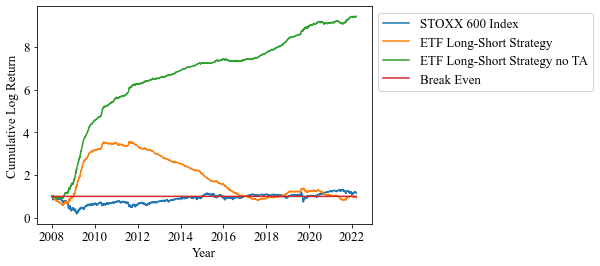

In [44]:
# Plot cumulative log returns of strategy + strategy with no transaction costs to STOXX 600 reference index

some_df = no_ta_final_df[["ProperDate", "year", "total_return_log_no_ta"]].merge(final_df[["ProperDate", "total_return_log"]], how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
present_df = some_df.merge(stoxx600_df[["ProperDate", "Close"]], how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
present_df['stoxx600_return'] = (present_df['Close'].pct_change())
present_df['stoxx600_return_log'] = present_df.apply(lambda row: math.log(1 + row.stoxx600_return) , axis=1)
present_df = present_df.drop('Close', axis=1)
present_df = present_df.drop('stoxx600_return', axis=1)
for i in list(present_df.columns[1:]):
    present_df.at[0,i]=np.nan

present_df["ETF Long-Short Strategy"] = 1 + present_df.total_return_log.cumsum()
present_df["ETF Long-Short Strategy no TA"] = 1 + present_df.total_return_log_no_ta.cumsum()
present_df["STOXX 600 Index"] = 1 + present_df.stoxx600_return_log.cumsum()
present_df["Break Even"] = 1

present_df.at[0,"year"] = 2008

combined_plot = present_df.plot(x='year', y=['STOXX 600 Index',"ETF Long-Short Strategy", "ETF Long-Short Strategy no TA", "Break Even"])#, title="Long-Short Strategy Cumulative Returns")
combined_plot.set_xlabel("Year")
combined_plot.set_ylabel("Cumulative Log Return")

plt.legend(bbox_to_anchor=(1, 1))
combined_plot

In [45]:
# prepare and export data frame as a csv for comparison and merging with other group strategies

to_merge = capm_ff3_df[["ProperDate", "rf"]].copy()
export_df = to_merge.merge(final_df[["ProperDate", "total_return_pct"]], how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
export_df['return_max'] = export_df.apply(lambda row: row.total_return_pct - row.rf, axis=1)
clean_df = export_df[["ProperDate", "return_max"]]
clean_df["ProperDate"] = pd.to_datetime(clean_df['ProperDate'])
clean_df["Date"] = clean_df["ProperDate"].dt.to_period("M")
clean_df["ret_1"] = clean_df["return_max"] + 1
group = clean_df.groupby(["Date"])
clean_df["return_max"] = group["ret_1"].transform(np.product) - 1
for_export = clean_df.groupby("Date", as_index=False)["return_max"].mean()
#for_export.to_csv("rets_max.csv", encoding='utf-8', index=False) # uncomment this line to export pct returns to csv file

/var/folders/mz/j0cx373n65bfdx6knq_mx3yr0000gn/T/ipykernel_3156/1373795725.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["ProperDate"] = pd.to_datetime(clean_df['ProperDate'])
/var/folders/mz/j0cx373n65bfdx6knq_mx3yr0000gn/T/ipykernel_3156/1373795725.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Date"] = clean_df["ProperDate"].dt.to_period("M")


In [46]:
# Create cumulative (normal return)  data frame for normal, no transaction costs and reference index.

to_merge = capm_ff3_df[["ProperDate", "rf"]].copy()
export_df = to_merge.merge(final_df[["ProperDate", "total_return_pct"]], how='inner', left_on=["ProperDate"], right_on=["ProperDate"])
int_df = export_df.merge(no_ta_final_df[["ProperDate", "total_return_pct_no_ta"]], how='inner', left_on=["ProperDate"], right_on=["ProperDate"])

int_df['return_max'] = int_df.apply(lambda row: row.total_return_pct - row.rf, axis=1)
int_df['return_max_no_ta'] = int_df.apply(lambda row: row.total_return_pct_no_ta - row.rf, axis=1)
clean_df = int_df[["ProperDate", "return_max", "return_max_no_ta"]]
new_df = clean_df.merge(stoxx600_df[["ProperDate", "stoxx600_return"]], how='inner', left_on=["ProperDate"], right_on=["ProperDate"])

new_df["ProperDate"] = pd.to_datetime(new_df['ProperDate'])
new_df["Date"] = new_df["ProperDate"].dt.to_period("M")
new_df["ret_1"] = new_df["return_max"] + 1
new_df["ret_2"] = new_df["return_max_no_ta"] + 1
new_df["ret_3"] = new_df["stoxx600_return"] + 1
group = new_df.groupby(["Date"])
new_df["return_max"] = group["ret_1"].transform(np.product) - 1
new_df["return_max_no_ta"] = group["ret_2"].transform(np.product) - 1
new_df["stoxx600_return"] = group["ret_3"].transform(np.product) - 1
for_export = new_df.groupby("Date", as_index=False)["return_max"].mean()
for_export_1 = new_df.groupby("Date", as_index=False)["return_max_no_ta"].mean()
for_export_2 = new_df.groupby("Date", as_index=False)["stoxx600_return"].mean()

merge_df = for_export.merge(for_export_1, how='inner', left_on=["Date"], right_on=["Date"])
final_merge_df = merge_df.merge(for_export_2, how='inner', left_on=["Date"], right_on=["Date"])

for i in final_merge_df.columns[1:]:
    final_merge_df[i + "_cum"] = (1 + final_merge_df[i]).cumprod()

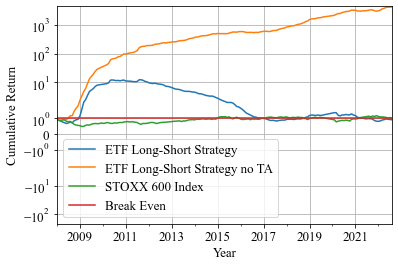

In [47]:
# Plot aforementioned cumulative returns (normal returns)

final_merge_df_plot = final_merge_df[["Date", "return_max_cum", "return_max_no_ta_cum", "stoxx600_return_cum"]].copy()
final_merge_df_plot.rename(columns = {'return_max_cum':'ETF Long-Short Strategy', 'return_max_no_ta_cum':'ETF Long-Short Strategy no TA', 'stoxx600_return_cum':'STOXX 600 Index'}, inplace = True)
final_merge_df_plot["Break Even"] = 1
graph = final_merge_df_plot.plot(x="Date", y=list(final_merge_df_plot.columns[1:]), grid=True)
graph.set_xlabel("Year")
graph.set_ylabel("Cumulative Return")
plt.yscale('symlog')

In [48]:
# Create subsample to evaluate performance (log) in different periods

full_sample = np.log(1 + for_export["return_max"])
full_sample_no_ta =np.log(1 + for_export_1["return_max_no_ta"])
first_half_sample = np.log(1 + for_export["return_max"])[:int(round(len(np.log(1 + for_export["return_max"]))/2,0))]
first_3_years = np.log(1 + for_export["return_max"])[:36]
second_half_sample = np.log(1 + for_export["return_max"])[int(round(len(np.log(1 + for_export["return_max"]))/2,0)):]

In [49]:
def calc_MDD(input):
  df = pd.Series(input, name="nw").to_frame()

  max_peaks_idx = df.nw.expanding(min_periods=1).apply(lambda x: x.argmax()).fillna(0).astype(int)
  df['max_peaks_idx'] = pd.Series(max_peaks_idx).to_frame()

  nw_peaks = pd.Series(df.nw.iloc[max_peaks_idx.values].values, index=df.nw.index)

  df['dd'] = ((df.nw-nw_peaks)/nw_peaks)
  df['mdd'] = df.groupby('max_peaks_idx').dd.apply(lambda x: x.expanding(min_periods=1).apply(lambda y: y.min())).fillna(0)

  return df

  #calc_MDD((1+ew_port_returns).cumprod())["mdd"].min()*100 # starting at 1 cumulative return

In [50]:
first_3_years.cumsum() + 1

0     0.927362
1     0.840493
2     0.793466
3     0.716162
4     0.648257
5     0.581318
6     0.642783
7     0.708474
8     0.655771
9     0.817229
10    0.888799
11    0.917943
12    1.133073
13    1.439446
14    1.703332
15    1.906253
16    2.251155
17    2.562422
18    2.678870
19    2.789681
20    2.961097
21    3.066815
22    3.091393
23    3.112116
24    3.137990
25    3.172917
26    3.188186
27    3.255704
28    3.472850
29    3.483613
30    3.460611
31    3.427980
32    3.448757
33    3.414402
34    3.458464
35    3.475486
Name: return_max, dtype: float64

In [51]:
# First 3 years performance statistics

total_return = round((((first_3_years).cumsum()).iloc[-1])*100,2)
average_return = round((first_3_years.mean()*12)*100,2)
standard_deviation = round((first_3_years.std())*math.sqrt(12)*100,2)
kurtosis = round(first_3_years.kurt() - 3,2)
skew = round(first_3_years.skew(),2)
best_month = round(first_3_years.max()*100,2)
worst_month = round(first_3_years.min()*100,2)
positive_month = round(first_3_years[first_3_years > 0].shape[0] / len(first_3_years)*100,2)
mdd = round(calc_MDD((first_3_years.cumsum() + 1))["mdd"].min()*100,2)
print("First 3 years")
print(f"Total Return = {total_return}%")
print(f"Average Return = {average_return}%")
print(f"Standard Deviation = {standard_deviation}%")
print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
print(f"Exess Kurtosis = {kurtosis}")
print(f"Skewness = {skew}")
print(f"Best Month = {best_month}%")
print(f"Worst Month = {worst_month}%")
print(f"Positive Month = {positive_month}%")
print(f"Maximum Drawdown = {mdd}%")

First 3 years
Total Return = 247.55%
Average Return = 82.52%
Standard Deviation = 41.26%
Sharpe Ratio = 2.0
Exess Kurtosis = -3.2
Skewness = 0.81
Best Month = 34.49%
Worst Month = -8.69%
Positive Month = 72.22%
Maximum Drawdown = -37.31%


In [52]:
# First sample half performance statistics

total_return = round((((first_half_sample).cumsum()).iloc[-1])*100,2)
average_return = round((first_half_sample.mean()*12)*100,2)
standard_deviation = round((first_half_sample.std())*math.sqrt(12)*100,2)
kurtosis = round(first_half_sample.kurt() - 3,2)
skew = round(first_half_sample.skew(),2)
best_month = round(first_half_sample.max()*100,2)
worst_month = round(first_half_sample.min()*100,2)
positive_month = round(first_half_sample[first_half_sample > 0].shape[0] / len(first_half_sample)*100,2)
mdd = round(calc_MDD((first_half_sample.cumsum() + 1))["mdd"].min()*100,2)
print("First Half")
print(f"Total Return = {total_return}%")
print(f"Average Return = {average_return}%")
print(f"Standard Deviation = {standard_deviation}%")
print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
print(f"Exess Kurtosis = {kurtosis}")
print(f"Skewness = {skew}")
print(f"Best Month = {best_month}%")
print(f"Worst Month = {worst_month}%")
print(f"Positive Month = {positive_month}%")
print(f"Maximum Drawdown = {mdd}%")

First Half
Total Return = 93.23%
Average Return = 13.01%
Standard Deviation = 33.01%
Sharpe Ratio = 0.39
Exess Kurtosis = 0.03
Skewness = 1.82
Best Month = 34.49%
Worst Month = -9.16%
Positive Month = 37.21%
Maximum Drawdown = -44.81%


In [53]:
# Second sample half performance statistics

total_return = round((((second_half_sample).cumsum()).iloc[-1])*100,2)
average_return = round((second_half_sample.mean()*12)*100,2)
standard_deviation = round((second_half_sample.std())*math.sqrt(12)*100,2)
kurtosis = round(second_half_sample.kurt() - 3,2)
skew = round(second_half_sample.skew(),2)
best_month = round(second_half_sample.max()*100,2)
worst_month = round(second_half_sample.min()*100,2)
positive_month = round(second_half_sample[second_half_sample > 0].shape[0] / len(second_half_sample)*100,2)
mdd = round(calc_MDD((second_half_sample.cumsum() + 1))["mdd"].min()*100,2)
print("Second Half")
print(f"Total Return = {total_return}%")
print(f"Average Return = {average_return}%")
print(f"Standard Deviation = {standard_deviation}%")
print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
print(f"Exess Kurtosis = {kurtosis}")
print(f"Skewness = {skew}")
print(f"Best Month = {best_month}%")
print(f"Worst Month = {worst_month}%")
print(f"Positive Month = {positive_month}%")
print(f"Maximum Drawdown = {mdd}%")

Second Half
Total Return = -103.99%
Average Return = -14.68%
Standard Deviation = 14.48%
Sharpe Ratio = -1.01
Exess Kurtosis = -2.31
Skewness = 0.11
Best Month = 11.96%
Worst Month = -12.75%
Positive Month = 38.82%
Maximum Drawdown = -117.31%


In [54]:
# Full sample performance statistics

total_return = round((((full_sample).cumsum()).iloc[-1])*100,2)
average_return = round((full_sample.mean()*12)*100,2)
standard_deviation = round((full_sample.std())*math.sqrt(12)*100,2)
kurtosis = round(full_sample.kurt() - 3,2)
skew = round(full_sample.skew(),2)
best_month = round(full_sample.max()*100,2)
worst_month = round(full_sample.min()*100,2)
positive_month = round(full_sample[full_sample > 0].shape[0] / len(full_sample)*100,2)
#mdd = round((((full_sample).cumsum() - (full_sample).cumsum().cummax()).min()*100),2)
mdd = round(calc_MDD((full_sample.cumsum() + 1))["mdd"].min()*100,2)
print("Full Period")
print(f"Total Return = {total_return}%")
print(f"Average Return = {average_return}%")
print(f"Standard Deviation = {standard_deviation}%")
print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
print(f"Exess Kurtosis = {kurtosis}")
print(f"Skewness = {skew}")
print(f"Best Month = {best_month}%")
print(f"Worst Month = {worst_month}%")
print(f"Positive Month = {positive_month}%")
print(f"Maximum Drawdown = {mdd}%")

Full Period
Total Return = -10.76%
Average Return = -0.76%
Standard Deviation = 25.78%
Sharpe Ratio = -0.03
Exess Kurtosis = 3.43
Skewness = 2.2
Best Month = 34.49%
Worst Month = -12.75%
Positive Month = 38.01%
Maximum Drawdown = -77.95%


In [55]:
# Full sample no transaction costs performance statistics

total_return = round((((full_sample_no_ta).cumsum()).iloc[-1])*100,2)
average_return = round((full_sample_no_ta.mean()*12)*100,2)
standard_deviation = round((full_sample_no_ta.std())*math.sqrt(12)*100,2)
kurtosis = round(full_sample_no_ta.kurt() - 3,2)
skew = round(full_sample_no_ta.skew(),2)
best_month = round(full_sample_no_ta.max()*100,2)
worst_month = round(full_sample_no_ta.min()*100,2)
positive_month = round(full_sample_no_ta[full_sample_no_ta > 0].shape[0] / len(full_sample_no_ta)*100,2)
#mdd = round((((full_sample_no_ta).cumsum() - (full_sample_no_ta).cumsum().cummax()).min()*100),2)
mdd = round(calc_MDD((full_sample_no_ta.cumsum() + 1))["mdd"].min()*100,2)
print("Full Period - No TA")
print(f"Total Return = {total_return}%")
print(f"Average Return = {average_return}%")
print(f"Standard Deviation = {standard_deviation}%")
print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
print(f"Exess Kurtosis = {kurtosis}")
print(f"Skewness = {skew}")
print(f"Best Month = {best_month}%")
print(f"Worst Month = {worst_month}%")
print(f"Positive Month = {positive_month}%")
print(f"Maximum Drawdown = {mdd}%")

Full Period - No TA
Total Return = 835.95%
Average Return = 58.66%
Standard Deviation = 26.4%
Sharpe Ratio = 2.22
Exess Kurtosis = 4.21
Skewness = 2.45
Best Month = 40.18%
Worst Month = -7.12%
Positive Month = 80.7%
Maximum Drawdown = -8.35%


In [56]:
# full sample no transaction costs (normal returns) performance statsitics

fullsample_no_pct = for_export_1.iloc[0:121]["return_max_no_ta"]


total_return = round(((1 + fullsample_no_pct).cumprod()-1).iloc[-1]*100,2)
average_return = round((fullsample_no_pct.mean()*12)*100,2)
standard_deviation = round((fullsample_no_pct.std())*math.sqrt(12)*100,2)
kurtosis = round(fullsample_no_pct.kurt() - 3,2)
skew = round(fullsample_no_pct.skew(),2)
best_month = round(fullsample_no_pct.max()*100,2)
worst_month = round(fullsample_no_pct.min()*100,2)
positive_month = round(fullsample_no_pct[fullsample_no_pct > 0].shape[0] / len(fullsample_no_pct)*100,2)
#mdd = round((((1 + fullsample_no_pct).cumprod() - (1 + fullsample_no_pct).cumprod().cummax()).min()*100),2)
mdd = round(calc_MDD((1+fullsample_no_pct).cumprod())["mdd"].min()*100,2)
print("PCT return no TA")
print(f"Total Return = {total_return}%")
print(f"Average Yearly Return = {average_return}%")
print(f"Standard Deviation = {standard_deviation}%")
print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
print(f"Exess Kurtosis = {kurtosis}")
print(f"Skewness = {skew}")
print(f"Best Month = {best_month}%")
print(f"Worst Month = {worst_month}%")
print(f"Positive Month = {positive_month}%")
print(f"Maximum Drawdown = {mdd}%")
print(" ")

PCT return no TA
Total Return = 84216.93%
Average Yearly Return = 73.69%
Standard Deviation = 34.92%
Sharpe Ratio = 2.11
Exess Kurtosis = 3.43
Skewness = 2.5
Best Month = 49.46%
Worst Month = -4.08%
Positive Month = 79.34%
Maximum Drawdown = -8.38%
 


In [57]:
# keep this line at the end of the notebook so that the notebook can be run again. In case that doesnt work restart the kernel and run all again

os.chdir(start_wd)